::: {.callout-note collapse="false"}
## Learning Outcomes
- Understanding KDE for plotting distributions and estimating density curves.
- Using transformations to analyze the relationship between two variables.
- Evaluating the quality of a visualization based on visualization theory concepts.
:::

## Kernel Density Estimation
Often, we want to identify general trends across a distribution, rather than focus on detail. Smoothing a distribution helps generalize the structure of the data and eliminate noise.

### KDE Theory

A **kernel density estimate (KDE)** is a smooth, continuous function that approximates a curve. It allows us to represent general trends in a distribution without focusing on the details, which is useful for analyzing the broad structure of a dataset. 

More formally, a KDE attempts to approximate the underlying **probability distribution** from which our dataset was drawn. You may have encountered the idea of a probability distribution in your other classes; if not, we'll discuss it at length in the next lecture. For now, you can think of a probability distribution as a description of how likely it is for us to sample a particular value in our dataset. 

A KDE curve estimates the probability density function of a random variable. Consider the example below, where we have used `sns.displot` to plot both a histogram (containing the data points we actually collected) and a KDE curve (representing the *approximated* probability distribution from which this data was drawn) using data from the World Bank dataset (`wb`).

In [1]:
#| code-fold: true
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

wb = pd.read_csv("data/world_bank.csv", index_col=0)
wb = wb.rename(columns={'Antiretroviral therapy coverage: % of people living with HIV: 2015':"HIV rate",
                       'Gross national income per capita, Atlas method: $: 2016':'gni'})
wb.head()

,Continent,Country,Primary completion rate: Male: % of relevant age group: 2015,Primary completion rate: Female: % of relevant age group: 2015,Lower secondary completion rate: Male: % of relevant age group: 2015,Lower secondary completion rate: Female: % of relevant age group: 2015,Youth literacy rate: Male: % of ages 15-24: 2005-14,Youth literacy rate: Female: % of ages 15-24: 2005-14,Adult literacy rate: Male: % ages 15 and older: 2005-14,Adult literacy rate: Female: % ages 15 and older: 2005-14,...,Access to improved sanitation facilities: % of population: 1990,Access to improved sanitation facilities: % of population: 2015,Child immunization rate: Measles: % of children ages 12-23 months: 2015,Child immunization rate: DTP3: % of children ages 12-23 months: 2015,Children with acute respiratory infection taken to health provider: % of children under age 5 with ARI: 2009-2016,Children with diarrhea who received oral rehydration and continuous feeding: % of children under age 5 with diarrhea: 2009-2016,Children sleeping under treated bed nets: % of children under age 5: 2009-2016,Children with fever receiving antimalarial drugs: % of children under age 5 with fever: 2009-2016,Tuberculosis: Treatment success rate: % of new cases: 2014,Tuberculosis: Cases detection rate: % of new estimated cases: 2015
0,Africa,Algeria,106.0,105.0,68.0,85.0,96.0,92.0,83.0,68.0,...,80.0,88.0,95.0,95.0,66.0,42.0,NaN,NaN,88.0,80.0
1,Africa,Angola,NaN,NaN,NaN,NaN,79.0,67.0,82.0,60.0,...,22.0,52.0,55.0,64.0,NaN,NaN,25.9,28.3,34.0,64.0
2,Africa,Benin,83.0,73.0,50.0,37.0,55.0,31.0,41.0,18.0,...,7.0,20.0,75.0,79.0,23.0,33.0,72.7,25.9,89.0,61.0
3,Africa,Botswana,98.0,101.0,86.0,87.0,96.0,99.0,87.0,89.0,...,39.0,63.0,97.0,95.0,NaN,NaN,NaN,NaN,77.0,62.0
5,Africa,Burundi,58.0,66.0,35.0,30.0,90.0,88.0,89.0,85.0,...,42.0,48.0,93.0,94.0,55.0,43.0,53.8,25.4,91.0,51.0


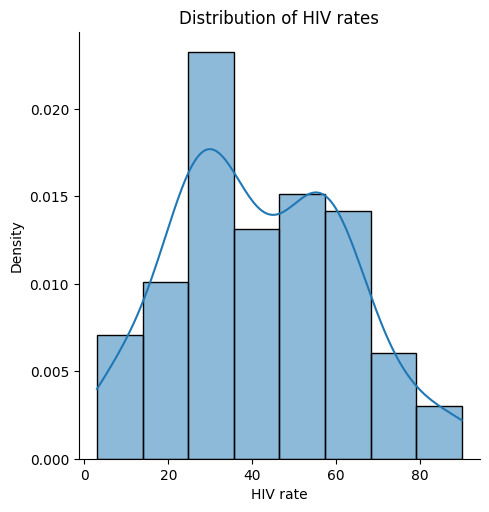

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data = wb, x = 'HIV rate', \
                       kde = True, stat = "density")

plt.title("Distribution of HIV rates");

Notice that the smooth KDE curve is higher when the histogram bins are taller. You can think of the height of the KDE curve as representing how "probable" it is that we randomly sample a datapoint with the corresponding value. This intuitively makes sense – if we have already collected more datapoints with a particular value (resulting in a tall histogram bin), it is more likely that, if we randomly sample another datapoint, we will sample one with a similar value (resulting in a high KDE curve).

The area under a probability density function should always integrate to 1, representing the fact that the total probability of a distribution should always sum to 100%. Hence, a KDE curve will always have an area under the curve of 1.

### Constructing a KDE

We perform kernel density estimation using three steps.

1. Place a kernel at each datapoint.
2. Normalize the kernels to have a total area of 1 (across all kernels).
3. Sum the normalized kernels.

We'll explain what a "kernel" is momentarily.

To make things simpler, let's construct a KDE for a small, artificially generated dataset of 5 datapoints: $[2.2, 2.8, 3.7, 5.3, 5.7]$. In the plot below, each vertical bar represents one data point.

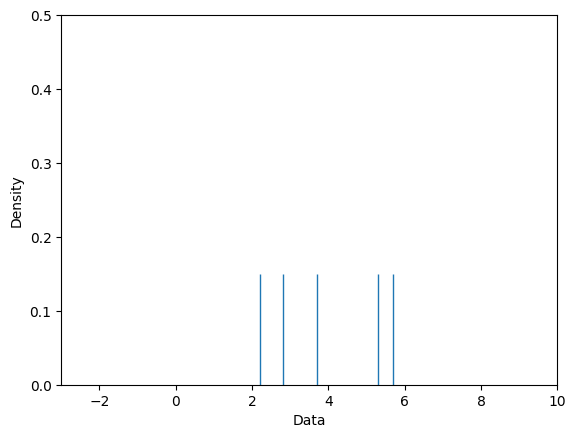

In [3]:
#| code-fold: true
data = [2.2, 2.8, 3.7, 5.3, 5.7]

sns.rugplot(data, height=0.3)

plt.xlabel("Data")
plt.ylabel("Density")
plt.xlim(-3, 10)
plt.ylim(0, 0.5);

Our goal is to create the following KDE curve, which was generated automatically by `sns.kdeplot`.

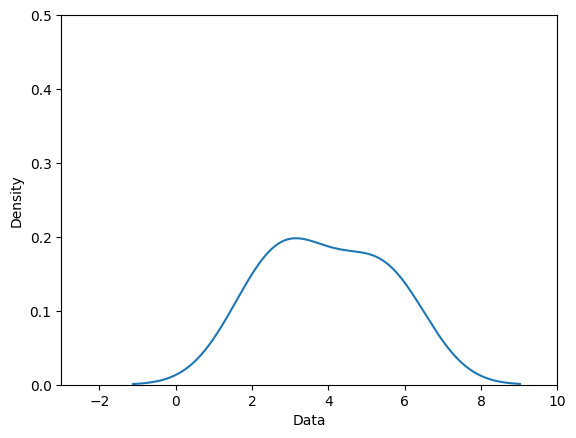

In [4]:
#| code-fold: true
sns.kdeplot(data)

plt.xlabel("Data")
plt.xlim(-3, 10)
plt.ylim(0, 0.5);

#### Step 1: Place a Kernel at Each Data Point

To begin generating a density curve, we need to choose a **kernel** and **bandwidth value ($\alpha$)**. What are these exactly? 

A **kernel** is a density curve. It is the mathematical function that attempts to capture the randomness of each data point in our sampled data. To explain what this means, consider just *one* of the datapoints in our dataset: $2.2$. We obtained this datapoint by randomly sampling some information out in the real world (you can imagine $2.2$ as representing a single measurement taken in an experiment, for example). If we were to sample a new datapoint, we may obtain a slightly different value. It could be higher than $2.2$; it could also be lower than $2.2$. We make the assumption that any future sampled datapoints will likely be similar in value to the data we've already drawn. This means that our *kernel* – our description of the probability of randomly sampling any new value – will be greatest at the datapoint we've already drawn but still have non-zero probability above and below it. The area under any kernel should integrate to 1, representing the total probability of drawing a new datapoint.

A **bandwidth value**, usually denoted by $\alpha$, represents the width of the kernel. A large value of $\alpha$ will result in a wide, short kernel function, while a small value with result in a narrow, tall kernel.

Below, we place a **Gaussian kernel**, plotted in orange, over the datapoint $2.2$. A Gaussian kernel is simply the normal distribution, which you may have called a bell curve in Data 8. 

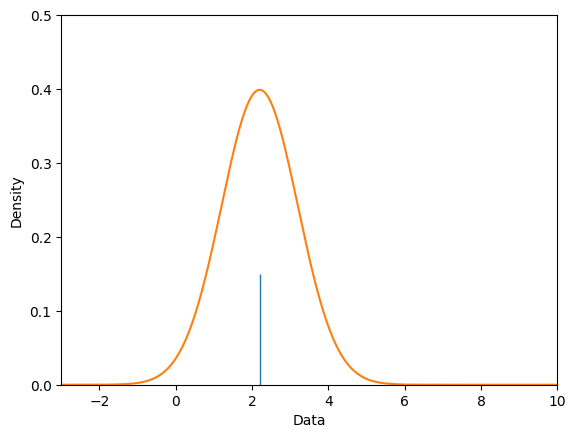

In [5]:
#| code-fold: true

def gaussian_kernel(x, z, a):
    # We'll discuss where this mathematical formulation came from later
    return (1/np.sqrt(2*np.pi*a**2)) * np.exp((-(x - z)**2 / (2 * a**2)))

# Plot our datapoint
sns.rugplot([2.2], height=0.3)

# Plot the kernel
x = np.linspace(-3, 10, 1000)
plt.plot(x, gaussian_kernel(x, 2.2, 1))

plt.xlabel("Data")
plt.ylabel("Density")
plt.xlim(-3, 10)
plt.ylim(0, 0.5);

To begin creating our KDE, we place a kernel on *each* datapoint in our dataset. For our dataset of 5 points, we will have 5 kernels.

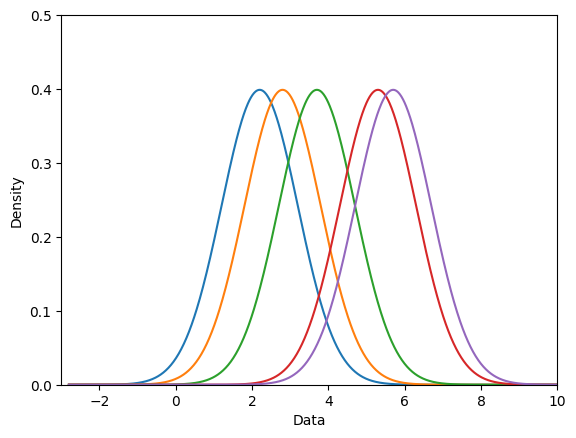

In [6]:
#| code-fold: true

# You will work with the functions below in Lab 4
def create_kde(kernel, pts, a):
    # Takes in a kernel, set of points, and alpha
    # Returns the KDE as a function
    def f(x):
        output = 0
        for pt in pts:
            output += kernel(x, pt, a)
        return output / len(pts) # Normalization factor
    return f

def plot_kde(kernel, pts, a):
    # Calls create_kde and plots the corresponding KDE
    f = create_kde(kernel, pts, a)
    x = np.linspace(min(pts) - 5, max(pts) + 5, 1000)
    y = [f(xi) for xi in x]
    plt.plot(x, y);
    
def plot_separate_kernels(kernel, pts, a, norm=False):
    # Plots individual kernels, which are then summed to create the KDE
    x = np.linspace(min(pts) - 5, max(pts) + 5, 1000)
    for pt in pts:
        y = kernel(x, pt, a)
        if norm:
            y /= len(pts)
        plt.plot(x, y)
    
    plt.show();
    
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plt.xlabel("Data")
plt.ylabel("Density")

plot_separate_kernels(gaussian_kernel, data, a = 1)

#### Step 2: Normalize Kernels to Have a Total Area of 1

Above, we said that *each* kernel has an area of 1. Earlier, we also said that our goal is to construct a KDE curve using these kernels with a *total* area of 1. If we were to directly sum the kernels as they are, we would produce a KDE curve with an integrated area of (5 kernels) $\times$ (area of 1 each) = 5. To avoid this, we will **normalize** each of our kernels. This involves multiplying each kernel by $\frac{1}{\#\:\text{datapoints}}$. 

In the cell below, we multiply each of our 5 kernels by $\frac{1}{5}$ to apply normalization.

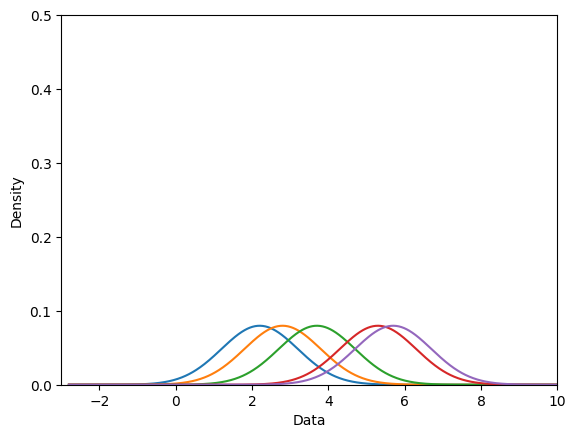

In [7]:
#| code-fold: true
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plt.xlabel("Data")
plt.ylabel("Density")

# The `norm` argument specifies whether or not to normalize the kernels
plot_separate_kernels(gaussian_kernel, data, a = 1, norm = True)

#### Step 3: Sum the Normalized Kernels

Our KDE curve is the sum of the normalized kernels. Notice that the final curve is identical to the plot generated by `sns.kdeplot` we saw earlier!

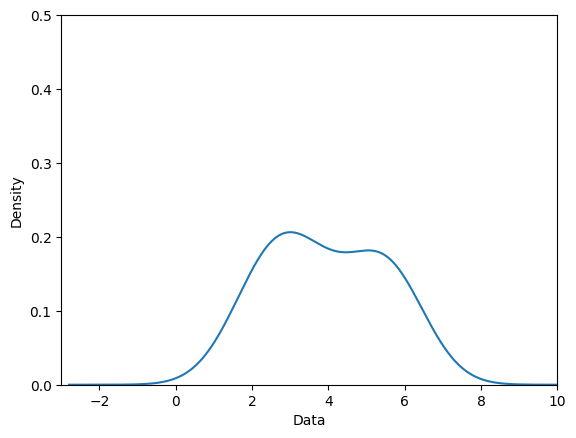

In [8]:
#| code-fold: true
plt.xlim(-3, 10)
plt.ylim(0, 0.5)
plt.xlabel("Data")
plt.ylabel("Density")

plot_kde(gaussian_kernel, data, a = 1)

### Kernel Functions and Bandwidths

<center><img src = "images/kde_function.png" width = "345"></img></a></center>

A general “KDE formula” function is given above.

1. $K_{\alpha}(x, x_i)$ is the kernel centered on the observation `i`. 
    - Each kernel individually has area 1.
    - x represents any number on the number line. It is the input to our function.
2. $n$ is the number of observed datapoints that we have.
    - We multiply by $\frac{1}{n}$ so that the total area of the KDE is still 1.
3. Each $x_i \in \{x_1, x_2, \dots, x_n\}$ represents an observed datapoint. 
    - These are what we use to create our KDE by summing multiple shifted kernels centered at these points.

* $\alpha$ (alpha) is the bandwidth or smoothing parameter. 

A **kernel** (for our purposes) is a valid density function. This means it:

- Must be non-negative for all inputs.
- Must integrate to 1.

#### Gaussian Kernel

The most common kernel is the **Gaussian kernel**. The Gaussian kernel is equivalent to the Gaussian probability density function (the Normal distribution), centered at the observed value with a standard deviation of (this is known as the **bandwidth** parameter).

$$K_a(x, x_i) = \frac{1}{\sqrt{2\pi\alpha^{2}}}e^{-\frac{(x-x_i)^{2}}{2\alpha^{2}}}$$

In this formula:

* $x$ (no subscript) represents any value along the x-axis of our plot
* $x_i$ represents the $i$ -th datapoint in our dataset. It is one of the values that we have actually collected in our data sampling process. In our example earlier, $x_i=2.2$. Those of you who have taken a probability class may recognize $x_i$ as the **mean** of the normal distribution.
* Each kernel is **centered** on our observed values, so its distribution mean is $x_i$.
* $\alpha$ is the bandwidth parameter, representing the width of our kernel. More formally, $\alpha$ is the **standard deviation** of the Gaussian curve.
    * A large value of $\alpha$ will produce a kernel that is wider and shorter – this leads to a smoother KDE when the kernels are summed together.
    * A small value of $\alpha$ will produce a narrower, taller kernel, and, with it, a noisier KDE.

The details of this (admittedly intimidating) formula are less important than understanding its role in kernel density estimation – this equation gives us the shape of each kernel.

| Gaussian Kernel, $\alpha$ = 0.1 | Gaussian Kernel, $\alpha$ = 1 | 
| --- | --- |
| <img src="images/gaussian_0.1.png" alt='gaussian_0.1' width='345'> | <img src="images/gaussian_1.png" alt='gaussian_1' width='345'> | 

| Gaussian Kernel, $\alpha$ = 2 | Gaussian Kernel, $\alpha$ = 10 | 
|  --- | --- | 
| <img src="images/gaussian_2.png" alt='gaussian_2' width='345'> | <img src="images/gaussian_10.png" alt='gaussian_10' width='345'> | 

#### Boxcar Kernel

Another example of a kernel is the **Boxcar kernel**. The boxcar kernel assigns a uniform density to points within a "window" of the observation, and a density of 0 elsewhere. The equation below is a boxcar kernel with the center at $x_i$ and the bandwidth of $\alpha$.

$$K_a(x, x_i) = \begin{cases}
        \frac{1}{\alpha}, & |x - x_i| \le \frac{\alpha}{2}\\
        0, & \text{else }
    \end{cases}$$
    
The boxcar kernel is seldom used in practice – we include it here to demonstrate that a kernel function can take whatever form you would like, provided it integrates to 1 and does not output negative values.

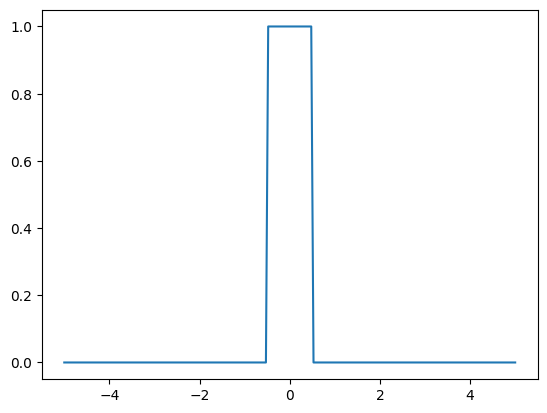

In [10]:
#| code-fold: true
#| fig-cap: The Boxcar kernel centered at 0 with bandwidth $\alpha$ = 1.

def boxcar_kernel(alpha, x, z):
    return (((x-z)>=-alpha/2)&((x-z)<=alpha/2))/alpha

xs = np.linspace(-5, 5, 200)
alpha=1
kde_curve = [boxcar_kernel(alpha, x, 0) for x in xs]
plt.plot(xs, kde_curve);

The diagram on the right is how the density curve for our 5 point dataset would have looked had we used the Boxcar kernel with bandwidth $\alpha$ = 1.

| KDE | Boxcar | 
| --- | --- | 
| <img src="images/gaussian_kernel.png" alt='kde_step_3' width='350'> | <img src="images/boxcar_kernel.png" alt='boxcar_kernel' width='350'> | 

#### Diving Deeper into `displot`

As we saw earlier, we can use `seaborn`'s `displot` function to plot various distributions. In particular, `displot` allows you to specify the `kind` of plot and is a wrapper for `histplot`, `kdeplot`, and `ecdfplot`.

Below, we can see a couple of examples of how `sns.displot` can be used to plot various distributions.

First, we can plot a histogram by setting `kind` to `"hist"`. Note that here we've specified `stat = density` to normalize the histogram such that the area under the histogram is equal to 1.

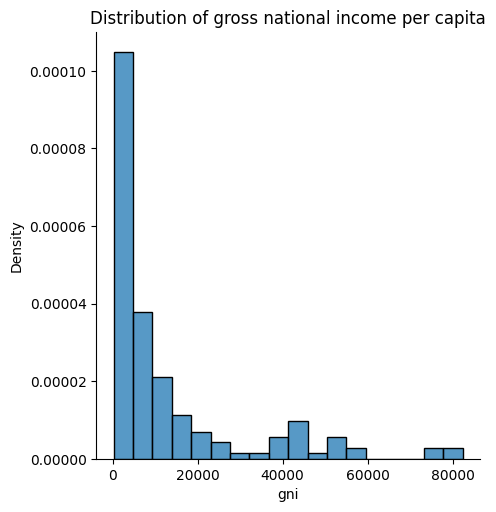

In [13]:
sns.displot(data=wb, 
            x="gni", 
            kind="hist", 
            stat="density") # default: stat=count and density integrates to 1
plt.title("Distribution of gross national income per capita");

Now, what if we want to generate a KDE plot? We can set `kind` = to `"kde"`! 

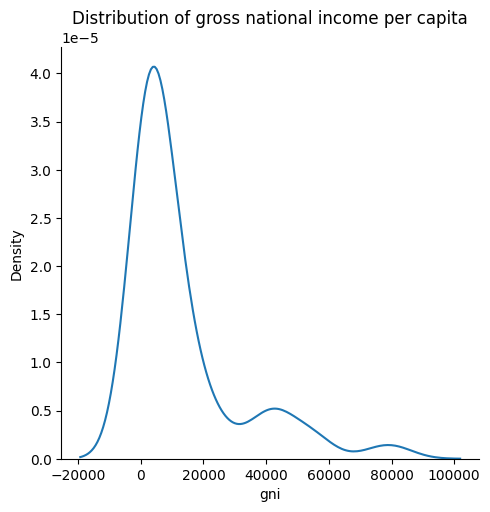

In [14]:
sns.displot(data=wb, 
            x="gni", 
            kind='kde')
plt.title("Distribution of gross national income per capita");

And finally, if we want to generate an Empirical Cumulative Distribution Function (ECDF), we can specify `kind = "ecdf"`.

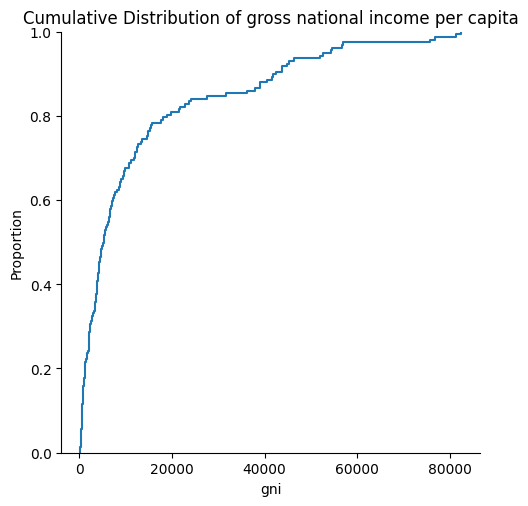

In [15]:
sns.displot(data=wb, 
            x="gni", 
            kind='ecdf')
plt.title("Cumulative Distribution of gross national income per capita");

## Relationships Between Quantitative Variables

Up until now, we've discussed how to visualize single-variable distributions. Going beyond this, we want to understand the relationship between pairs of numerical variables.

#### Scatter Plots

**Scatter plots** are one of the most useful tools in representing the relationship between two quantitative variables. They are particularly important in gauging the strength, or correlation, of the relationship between variables. Knowledge of these relationships can then motivate decisions in our modeling process.

In `matplotlib`, we use the function `plt.scatter` to generate a scatter plot. Notice that, unlike our examples of plotting single-variable distributions, now we specify sequences of values to be plotted along the x-axis *and* the y-axis. 

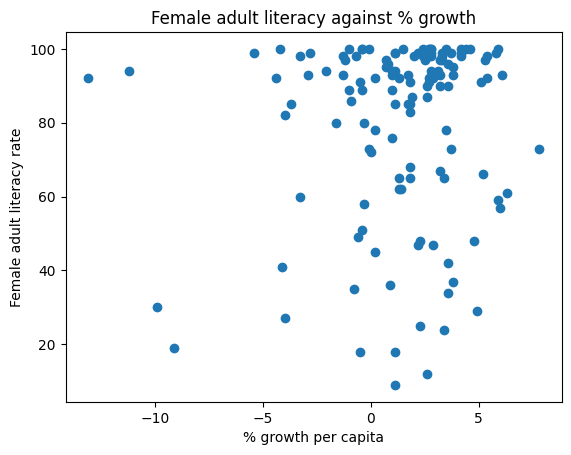

In [16]:
plt.scatter(wb["per capita: % growth: 2016"], \
            wb['Adult literacy rate: Female: % ages 15 and older: 2005-14'])

plt.xlabel("% growth per capita")
plt.ylabel("Female adult literacy rate")
plt.title("Female adult literacy against % growth");

In `seaborn`, we call the function `sns.scatterplot`. We use the `x` and `y` parameters to indicate the values to be plotted along the x and y axes, respectively. By using the `hue` parameter, we can specify a third variable to be used for coloring each scatter point.

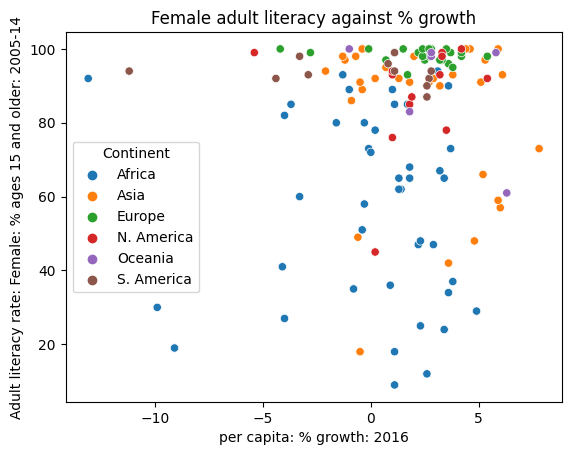

In [17]:
sns.scatterplot(data = wb, x = "per capita: % growth: 2016", \
               y = "Adult literacy rate: Female: % ages 15 and older: 2005-14", 
               hue = "Continent")

plt.title("Female adult literacy against % growth");

Although the plots above communicate the general relationship between the two plotted variables, they both suffer a major limitation – **overplotting**. Overplotting occurs when scatter points with similar values are stacked on top of one another, making it difficult to see the number of scatter points actually plotted in the visualization. Notice how in the upper righthand region of the plots, we cannot easily tell just how many points have been plotted. This makes our visualizations difficult to interpret. 

We have a few methods to help reduce overplotting:

* Decreasing the size of the scatter point markers can improve readability. We do this by setting a new value to the size parameter, `s`, of `plt.scatter` or `sns.scatterplot`.
* **Jittering** is the process of adding a small amount of random noise to all x and y values to slightly shift the position of each datapoint. By randomly shifting all the data by some small distance, we can discern individual points more clearly without modifying the major trends of the original dataset.

In the cell below, we first jitter the data using `np.random.uniform`, then re-plot it with smaller markers. The resulting plot is much easier to interpret.

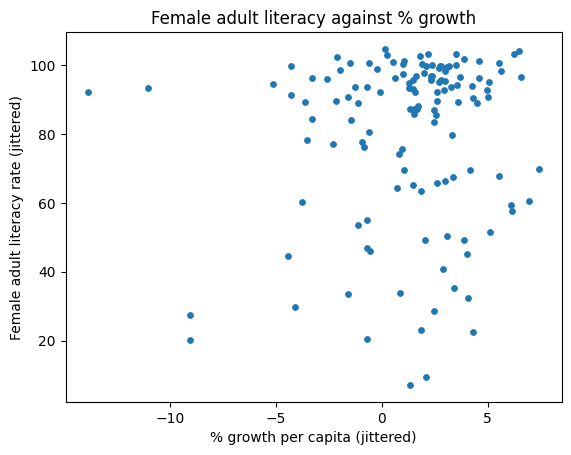

In [18]:
# Setting a seed ensures that we produce the same plot each time
# This means that the course notes will not change each time you access them
np.random.seed(150)

# This call to np.random.uniform generates random numbers between -1 and 1
# We add these random numbers to the original x data to jitter it slightly
x_noise = np.random.uniform(-1, 1, len(wb))
jittered_x = wb["per capita: % growth: 2016"] + x_noise

# Repeat for y data
y_noise = np.random.uniform(-5, 5, len(wb))
jittered_y = wb["Adult literacy rate: Female: % ages 15 and older: 2005-14"] + y_noise

# Setting the size parameter `s` changes the size of each point
plt.scatter(jittered_x, jittered_y, s=15)

plt.xlabel("% growth per capita (jittered)")
plt.ylabel("Female adult literacy rate (jittered)")
plt.title("Female adult literacy against % growth");

#### `lmplot` and `jointplot`

`seaborn` also includes several built-in functions for creating more sophisticated scatter plots. Two of the most commonly used examples are `sns.lmplot` and `sns.jointplot`. 

`sns.lmplot` plots both a scatter plot *and* a linear regression line, all in one function call. We'll discuss linear regression in a few lectures. 

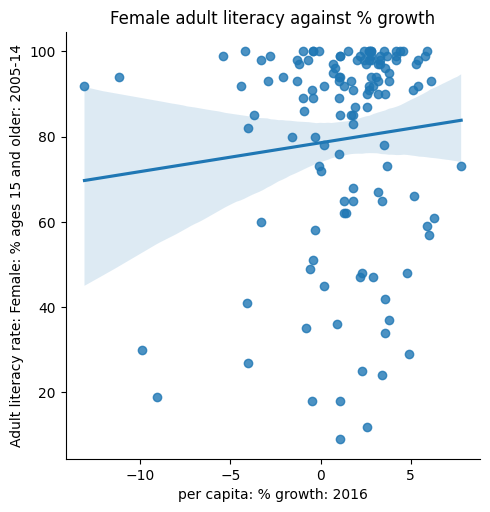

In [19]:
sns.lmplot(data = wb, x = "per capita: % growth: 2016", \
           y = "Adult literacy rate: Female: % ages 15 and older: 2005-14")

plt.title("Female adult literacy against % growth");

`sns.jointplot` creates a visualization with three components: a scatter plot, a histogram of the distribution of x values, and a histogram of the distribution of y values.

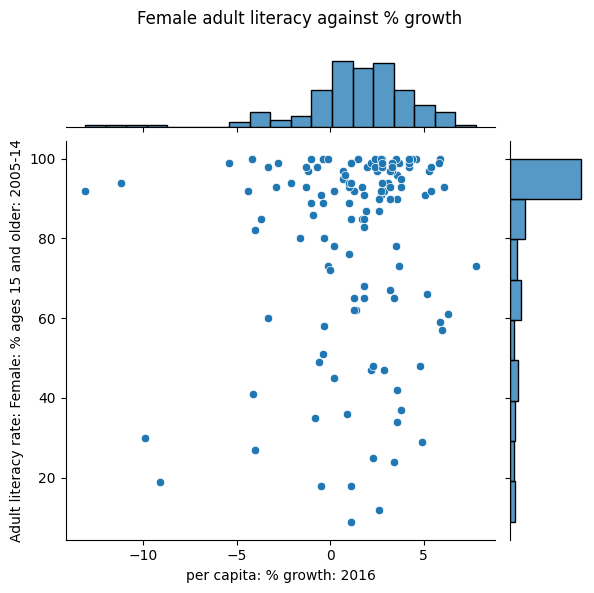

In [20]:
sns.jointplot(data = wb, x = "per capita: % growth: 2016", \
           y = "Adult literacy rate: Female: % ages 15 and older: 2005-14")

# plt.suptitle allows us to shift the title up so it does not overlap with the histogram
plt.suptitle("Female adult literacy against % growth")
plt.subplots_adjust(top=0.9);

#### Hex plots
For datasets with a very large number of datapoints, jittering is unlikely to fully resolve the issue of overplotting. In these cases, we can attempt to visualize our data by its *density*, rather than displaying each individual datapoint.

**Hex plots** can be thought of as two-dimensional histograms that show the joint distribution between two variables. This is particularly useful when working with very dense data. In a hex plot, the x-y plane is binned into hexagons. Hexagons that are darker in color indicate a greater density of data – that is, there are more data points that lie in the region enclosed by the hexagon.

We can generate a hex plot using `sns.jointplot` modified with the `kind` parameter.

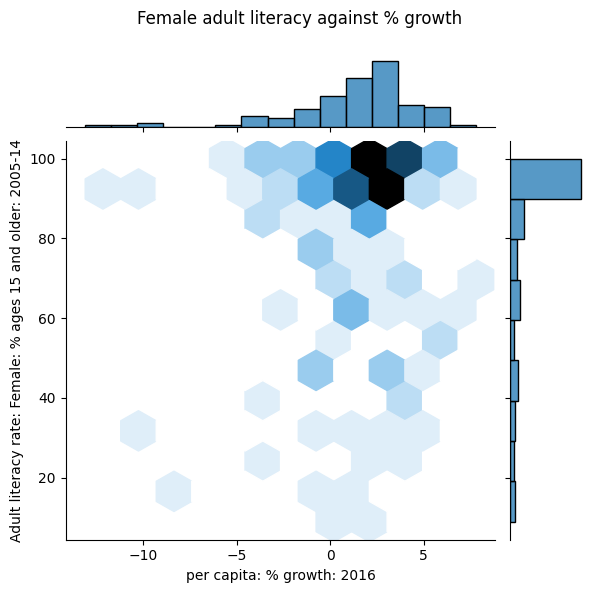

In [21]:
sns.jointplot(data = wb, x = "per capita: % growth: 2016", \
              y = "Adult literacy rate: Female: % ages 15 and older: 2005-14", \
              kind = "hex")

# plt.suptitle allows us to shift the title up so it does not overlap with the histogram
plt.suptitle("Female adult literacy against % growth")
plt.subplots_adjust(top=0.9);

#### Contour Plots

**Contour plots** are an alternative way of plotting the joint distribution of two variables. You can think of them as the 2-dimensional versions of KDE plots. A contour plot can be interpreted in a similar way to a [topographic map](https://gisgeography.com/contour-lines-topographic-map/). Each contour line represents an area that has the same *density* of datapoints throughout the region. Contours marked with darker colors contain more datapoints (a higher density) in that region.

`sns.kdeplot` will generate a contour plot if we specify both x and y data.

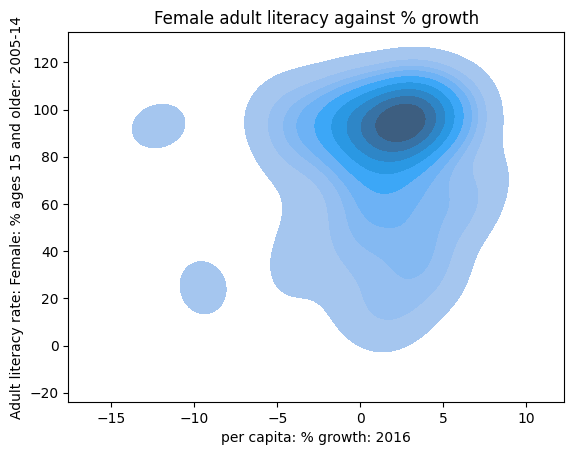

In [22]:
sns.kdeplot(data = wb, x = "per capita: % growth: 2016", \
            y = "Adult literacy rate: Female: % ages 15 and older: 2005-14", \
            fill = True)

plt.title("Female adult literacy against % growth");

## Transformations
We have now covered visualizations in great depth, looking into various forms of visualizations, plotting libraries, and high-level theory.

Much of this was done to uncover insights in data, which will prove necessary when we begin building models of data later in the course. A strong graphical correlation between two variables hints at an underlying relationship that we may want to study in greater detail. However, relying on visual relationships alone is limiting - not all plots show association. The presence of outliers and other statistical anomalies makes it hard to interpret data.

**Transformations** are the process of manipulating data to find significant relationships between variables. These are often found by applying mathematical functions to variables that "transform" their range of possible values and highlight some previously hidden associations between data.

To see why we may want to transform data, consider the following plot of adult literacy rates against gross national income.

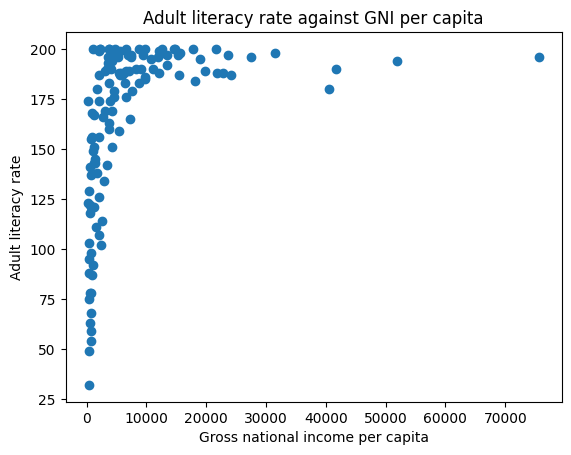

In [23]:
#| code-fold: true

# Some data cleaning to help with the next example
df = pd.DataFrame(index=wb.index)
df['lit'] = wb['Adult literacy rate: Female: % ages 15 and older: 2005-14'] \
            + wb["Adult literacy rate: Male: % ages 15 and older: 2005-14"]
df['inc'] = wb['gni']
df.dropna(inplace=True)

plt.scatter(df["inc"], df["lit"])
plt.xlabel("Gross national income per capita")
plt.ylabel("Adult literacy rate")
plt.title("Adult literacy rate against GNI per capita");

This plot is difficult to interpret for two reasons:

* The data shown in the visualization appears almost "smushed" – it is heavily concentrated in the upper lefthand region of the plot. Even if we jittered the dataset, we likely would not be able to fully assess all datapoints in that area.
* It is hard to generalize a clear relationship between the two plotted variables. While adult literacy rate appears to share some positive relationship with gross national income, we are not able to describe the specifics of this trend in much detail.

A transformation would allow us to visualize this data more clearly, which, in turn, would enable us to describe the underlying relationship between our variables of interest.

We will most commonly apply a transformation to **linearize a relationship** between variables. If we find a transformation to make a scatter plot of two variables linear, we can "backtrack" to find the exact relationship between the variables. This helps us in two major ways. Firstly, linear relationships are particularly simple to interpret – we have an intuitive sense of what the slope and intercept of a linear trend represent, and how they can help us understand the relationship between two variables. Secondly, linear relationships are the backbone of linear models. We will begin exploring linear modeling in great detail next week. As we'll soon see, linear models become much more effective when we are working with linearized data.  

In the remainder of this note, we will discuss how to linearize a dataset to produce the result below. Notice that the resulting plot displays a rough linear relationship between the values plotted on the x and y axes.

<img src="images/linearize.png" alt='linearize' width='700'>

### Linearization and Applying Transformations

To linearize a relationship, begin by asking yourself: what makes the data non-linear? It is helpful to repeat this question for each variable in your visualization.

Let's start by considering the gross national income variable in our plot above. Looking at the y values in the scatter plot, we can see that many large y values are all clumped together, compressing the vertical axis. The scale of the horizontal axis is also being distorted by the few large outlying x values on the right. 

<img src="images/horizontal.png" alt='horizontal' width='450'>

If we decreased the size of these outliers relative to the bulk of the data, we could reduce the distortion of the horizontal axis. How can we do this? We need a transformation that will:

* Decrease the magnitude of large x values by a significant amount.
* Not drastically change the magnitude of small x values.

One function that produces this result is the **log transformation**. When we take the logarithm of a large number, the original number will decrease in magnitude dramatically. Conversely, when we take the logarithm of a small number, the original number does not change its value by as significant of an amount (to illustrate this, consider the difference between $\log{(100)} = 4.61$ and $\log{(10)} = 2.3$).

In Data 100 (and most upper-division STEM classes), $\log$ is used to refer to the natural logarithm with base $e$.

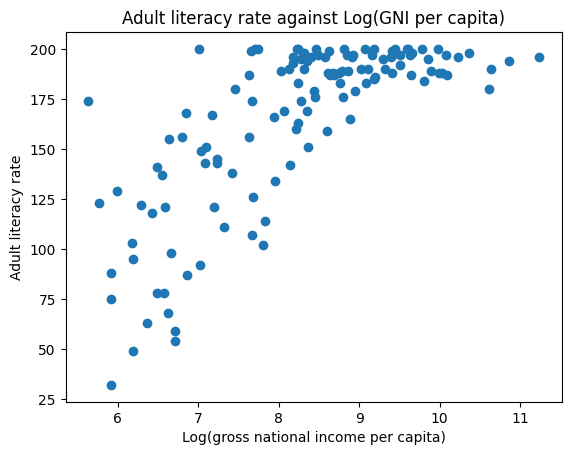

In [24]:
# np.log takes the logarithm of an array or Series
plt.scatter(np.log(df["inc"]), df["lit"])

plt.xlabel("Log(gross national income per capita)")
plt.ylabel("Adult literacy rate")
plt.title("Adult literacy rate against Log(GNI per capita)");

After taking the logarithm of our x values, our plot appears much more balanced in its horizontal scale. We no longer have many datapoints clumped on one end and a few outliers out at extreme values. 

Let's repeat this reasoning for the y values. Considering only the vertical axis of the plot, notice how there are many datapoints concentrated at large y values. Only a few datapoints lie at smaller values of y.

If we were to "spread out" these large values of y more, we would no longer see the dense concentration in one region of the y-axis. We need a transformation that will:

* Increase the magnitude of large values of y so these datapoints are distributed more broadly on the vertical scale,
* Not substantially alter the scaling of small values of y (we do not want to drastically modify the lower end of the y axis, which is already distributed evenly on the vertical scale).

In this case, it is helpful to apply a **power transformation** – that is, raise our y values to a power. Let's try raising our adult literacy rate values to the power of 4. Large values raised to the power of 4 will increase in magnitude proportionally much more than small values raised to the power of 4 (consider the difference between $2^4 = 16$ and $200^4 = 1600000000$). 

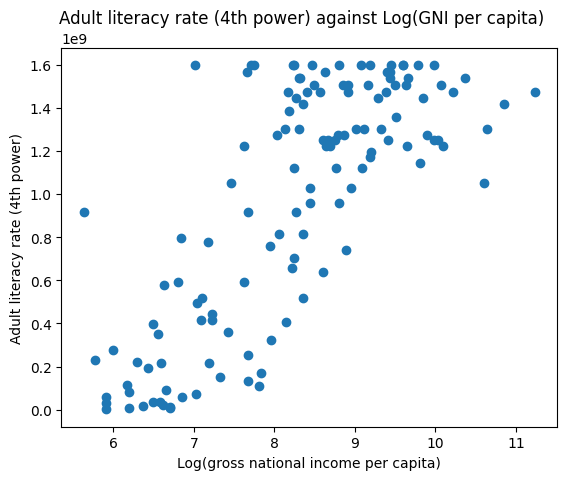

In [25]:
# Apply a log transformation to the x values and a power transformation to the y values
plt.scatter(np.log(df["inc"]), df["lit"]**4)

plt.xlabel("Log(gross national income per capita)")
plt.ylabel("Adult literacy rate (4th power)")
plt.suptitle("Adult literacy rate (4th power) against Log(GNI per capita)")
plt.subplots_adjust(top=0.9);

Our scatter plot is looking a lot better! Now, we are plotting the log of our original x values on the horizontal axis, and the 4th power of our original y values on the vertical axis. We start to see an approximate *linear* relationship between our transformed variables. 

What can we take away from this? We now know that the log of gross national income and adult literacy to the power of 4 are roughly linearly related. If we denote the original, untransformed gross national income values as $x$ and the original adult literacy rate values as $y$, we can use the standard form of a linear fit to express this relationship:

$$y^4 = m(\log{x}) + b$$

Where $m$ represents the slope of the linear fit, while $b$ represents the intercept. 

The cell below computes $m$ and $b$ for our transformed data. We'll discuss how this code was generated in a future lecture.

The slope, m, of the transformed data is: 336400693.43172705
The intercept, b, of the transformed data is: -1802204836.0479987


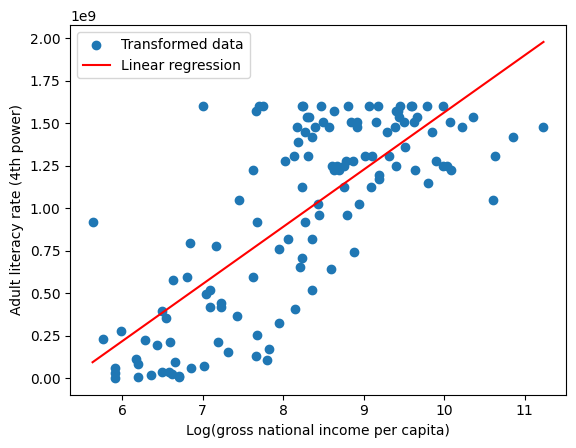

In [26]:
#| code-fold: true
# The code below fits a linear regression model. We'll discuss it at length in a future lecture
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.log(df[["inc"]]), df["lit"]**4)
m, b = model.coef_[0], model.intercept_

print(f"The slope, m, of the transformed data is: {m}")
print(f"The intercept, b, of the transformed data is: {b}")

df = df.sort_values("inc")
plt.scatter(np.log(df["inc"]), df["lit"]**4, label="Transformed data")
plt.plot(np.log(df["inc"]), m*np.log(df["inc"])+b, c="red", label="Linear regression")
plt.xlabel("Log(gross national income per capita)")
plt.ylabel("Adult literacy rate (4th power)")
plt.legend();

What if we want to understand the *underlying* relationship between our original variables, before they were transformed? We can simply rearrange our linear expression above! 

Recall our linear relationship between the transformed variables $\log{x}$ and $y^4$. 

$$y^4 = m(\log{x}) + b$$

By rearranging the equation, we find a relationship between the untransformed variables $x$ and $y$. 

$$y = [m(\log{x}) + b]^{(1/4)}$$

When we plug in the values for $m$ and $b$ computed above, something interesting happens.

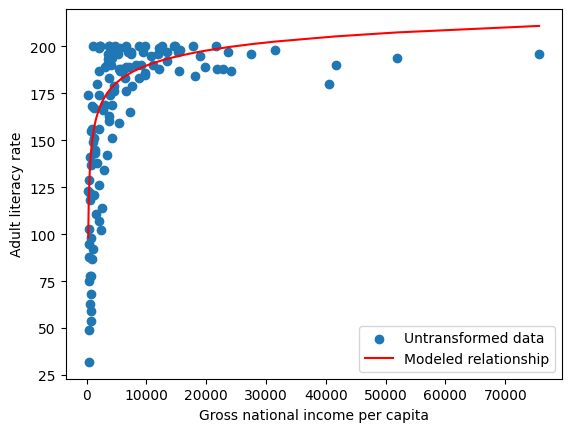

In [27]:
#| code-fold: true
# Now, plug the values for m and b into the relationship between the untransformed x and y
plt.scatter(df["inc"], df["lit"], label="Untransformed data")
plt.plot(df["inc"], (m*np.log(df["inc"])+b)**(1/4), c="red", label="Modeled relationship")
plt.xlabel("Gross national income per capita")
plt.ylabel("Adult literacy rate")
plt.legend();

We have found a relationship between our original variables – gross national income and adult literacy rate!

Transformations are powerful tools for understanding our data in greater detail. To summarize what we just achieved:

* We identified appropriate transformations to **linearize** the original data.
* We used our knowledge of linear curves to compute the slope and intercept of the transformed data.
* We used this slope and intercept information to derive a relationship in the untransformed data.

Linearization will be an important tool as we begin our work on linear modeling next week.

#### Tukey-Mosteller Bulge Diagram

The **Tukey-Mosteller Bulge Diagram** is a good guide when determining possible transformations to achieve linearity. It is a visual summary of the reasoning we just worked through above. 

<img src="images/tukey_mosteller.png" alt='tukey_mosteller' width='300'>

How does it work? Each curved "bulge" represents a possible shape of non-linear data. To use the diagram, find which of the four bulges resembles your dataset the most closely. Then, look at the axes of the quadrant for this bulge. The horizontal axis will list possible transformations that could be applied to your x data for linearization. Similarly, the vertical axis will list possible transformations that could be applied to your y data. Note that each axis lists two possible transformations. While *either* of these transformations has the *potential* to linearize your dataset, note that this is an iterative process. It's important to try out these transformations and look at the results to see whether you've actually achieved linearity. If not, you'll need to continue testing other possible transformations.

Generally:

* $\sqrt{}$ and $\log{}$ will reduce the magnitude of large values.
* Powers ($^2$ and $^3$) will increase the spread in magnitude of large values.


<img src="images/bulge.png" alt='bulge' width='800'>


**Important:** You should still understand the *logic* we worked through to determine how best to transform the data. The bulge diagram is just a summary of this same reasoning. You will be expected to be able to explain why a given transformation is or is not appropriate for linearization.

### Additional Remarks

Visualization requires a lot of thought!

- There are many tools for visualizing distributions.
    - Distribution of a single variable:
        1. Rugplot
        2. Histogram
        3. Density plot
        4. Box plot
        5. Violin plot
    - Joint distribution of two quantitative variables: 
        1. Scatter plot
        2. Hex plot
        3. Contour plot

This class primarily uses `seaborn` and `matplotlib`, but `pandas` also has basic built-in plotting methods. Many other visualization libraries exist, and `plotly` is one of them.

- `plotly` creates very easily creates interactive plots.
- `plotly` will occasionally appear in lecture code, labs, and assignments! 

Next, we’ll go deeper into the theory behind visualization.

## Visualization Theory

This section marks a pivot to the second major topic of this lecture - visualization theory. We'll discuss the abstract nature of visualizations and analyze how they convey information.

Remember, we had two goals for visualizing data. This section is particularly important in:

1. Helping us understand the data and results,
2. Communicating our results and conclusions with others.

### Information Channels

Visualizations are able to convey information through various encodings. In the remainder of this lecture, we'll look at the use of color, scale, and depth, to name a few. 

#### Encodings in Rugplots

One detail that we may have overlooked in our earlier discussion of rugplots is the importance of encodings. Rugplots are effective visuals because they utilize line thickness to encode frequency. Consider the following diagram:

<img src="images/rugplot_encoding.png" alt='rugplot_encoding' width='600'> 

#### Multi-Dimensional Encodings

Encodings are also useful for representing multi-dimensional data. Notice how the following visual highlights four distinct "dimensions" of data:

- X-axis
- Y-axis
- Area
- Color

<img src="images/mutli_dim_encodings.png" alt='multi_dim_encoding' width='400'> 

The human visual perception system is only capable of visualizing data in a three-dimensional plane, but as you've seen, we can encode many more channels of information.

### Harnessing the Axes

#### Consider the Scale of the Data

However, we should be careful to not misrepresent relationships in our data by manipulating the scale or axes. The visualization below improperly portrays two seemingly independent relationships on the same plot. The authors have clearly changed the scale of the y-axis to mislead their audience.

<img src="images/wrong_scale_viz.png" alt='wrong_scale_viz' width='350'> 

Notice how the downwards-facing line segment contains values in the millions, while the upwards-trending segment only contains values near three hundred thousand. These lines should not be intersecting.

When there is a large difference in the magnitude of the data, it's advised to analyze percentages instead of counts. The following diagrams correctly display the trends in cancer screening and abortion rates. 

:::: {.columns}


::: {.column width="30%"}
<img src="images/good_viz_scale_1.png" alt='good_viz_scale_1' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/good_viz_scale_2.png" alt='good_viz_scale_2' width='345'>
:::

::::

#### Reveal the Data

Great visualizations not only consider the scale of the data but also utilize the axes in a way that best conveys information. For example, data scientists commonly set certain axes limits to highlight parts of the visualization they are most interested in.

:::: {.columns}


::: {.column width="30%"}
<img src="images/unrevealed_viz.png" alt='unrevealed_viz' width='345'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/revealed_viz.png" alt='revealed_viz' width='345'>
:::

::::

The visualization on the right captures the trend in coronavirus cases during March of 2020. From only looking at the visualization on the left, a viewer may incorrectly believe that coronavirus began to skyrocket on March 4^th^, 2020. However, the second illustration tells a different story - cases rose closer to March 21^th^, 2020.

### Harnessing Color

Color is another important feature in visualizations that does more than what meets the eye. 

We already explored using color to encode a categorical variable in our scatter plot. Let's now discuss the uses of color in novel visualizations like colormaps and heatmaps.

5-8% of the world is red-green color blind, so we have to be very particular about our color scheme. We want to make these as accessible as possible. Choosing a set of colors that work together is evidently a challenging task!

#### Colormaps

Colormaps are mappings from pixel data to color values, and they're often used to highlight distinct parts of an image. Let's investigate a few properties of colormaps.

:::: {.columns}


::: {.column width="30%"}
**Jet Colormap**
<img src="images/jet_colormap.png" alt='jet_colormap' width='250'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Viridis Colormap**
<img src="images/viridis_colormap.png" alt='viridis_colormap' width='250'>
:::

::::

The jet colormap is infamous for being misleading. While it seems more vibrant than viridis, the aggressive colors poorly encode numerical data. To understand why, let's analyze the following images.

:::: {.columns}


::: {.column width="30%"}
<img src="images/jet_four_by_four.png" alt='four_by_four_colormap' width='300'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/jet_3_images.png" alt='jet_3_colormap' width='250'>
:::

::::

The diagram on the left compares how a variety of colormaps represent pixel data that transitions from a high to low intensity. These include the jet colormap (row a) and grayscale (row b). Notice how the grayscale images do the best job in smoothly transitioning between pixel data. The jet colormap is the worst at this - the four images in row (a) look like a conglomeration of individual colors. 

The difference is also evident in the images labeled (a) and (b) on the left side. The grayscale image is better at preserving finer detail in the vertical line strokes. Additionally, grayscale is preferred in X-ray scans for being more neutral. The intensity of the dark red color in the jet colormap is frightening and indicates something is wrong.

Why is the jet colormap so much worse? The answer lies in how its color composition is perceived to the human eye.

:::: {.columns}


::: {.column width="30%"}
**Jet Colormap Perception**
<img src="images/jet_perceptually_uniform.png" alt='jet_perceptually_uniform' width='300'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
**Viridis Colormap Perception**
<img src="images/viridis_perceptually_uniform.png" alt='viridis_perceptually_uniform' width='336'>
:::

::::

The jet colormap is largely misleading because it is not perceptually uniform. **Perceptually uniform colormaps** have the property that if the pixel data goes from 0.1 to 0.2, the perceptual change is the same as when the data goes from 0.8 to 0.9.

Notice how the said uniformity is present within the linear trend displayed in the viridis colormap. On the other hand, the jet colormap is largely non-linear - this is precisely why it's considered a worse colormap.

### Harnessing Markings

In our earlier discussion of multi-dimensional encodings, we analyzed a scatter plot with four pseudo-dimensions: the two axes, area, and color. Were these appropriate to use? The following diagram analyzes how well the human eye can distinguish between these "markings".

<img src="images/markings_viz.png" alt='markings_viz' width='300'>

There are a few key takeaways from this diagram

- Lengths are easy to discern. Don't use plots with jiggled baselines - keep everything axis-aligned.
- Avoid pie charts! Angle judgments are inaccurate.
- Areas and volumes are hard to distinguish (area charts, word clouds, etc.).

### Harnessing Conditioning

Conditioning is the process of comparing data that belong to separate groups. We've seen this before in overlayed distributions, side-by-side box plots, and scatter plots with categorical encodings. Here, we'll introduce terminology that formalizes these examples.

Consider an example where we want to analyze income earnings for males and females with varying levels of education. There are multiple ways to compare this data. 

:::: {.columns}


::: {.column width="30%"}
<img src="images/male_female_earnings_barplot.png" alt='jet_perceptually_uniform' width='360'>
:::

::: {.column width="20%"}
<!-- empty column to create gap -->
:::

::: {.column width="30%"}
<img src="images/male_female_earnings_scatterplot.png" alt='viridis_perceptually_uniform' width='340'>
:::

::::

The barplot is an example of **juxtaposition**: placing multiple plots side by side, with the same scale. The scatter plot is an example of **superposition**: placing multiple density curves and scatter plots on top of each other. 

Which is better depends on the problem at hand. Here, superposition makes the precise wage difference very clear from a quick glance. However, many sophisticated plots convey information that favors the use of juxtaposition. Below is one example.

<img src="images/small_multiples.png" alt='small_multiples' width='600'>
                                                        

### Harnessing Context

The last component of a great visualization is perhaps the most critical - the use of context. Adding informative titles, axis labels, and descriptive captions are all best practices that we've heard repeatedly in Data 8.

A publication-ready plot (and every Data 100 plot) needs:

- Informative title (takeaway, not description),
- Axis labels,
- Reference lines, markers, etc,
- Legends, if appropriate,
- Captions that describe data,

Captions should:

- Be comprehensive and self-contained,
- Describe what has been graphed,
- Draw attention to important features,
- Describe conclusions drawn from graphs.